In [71]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV

from xgboost import XGBClassifier

from utils import elo_predict, fiveodds, last_with_nan, MatchElo, SetsElo, get_player_points

In [2]:
round_dict = {
    'RR' : 0,
    'ER' : 0,
    'BR' : 0,
    'Q1' : 1,
    'R128' : 1,
    'Q2' : 2,
    'R64' : 2,
    'Q3' : 3,
    'R32' : 3,
    'R16' : 4,
    'QF' : 5,
    'Q4' : 5,
    'SF' : 6,
    'F' : 7
}

In [5]:
folder = "./tennis_atp"

df = pd.DataFrame()

for file in os.listdir(f'{folder}'):

    if file.endswith('csv') and '20' in file and 'doubles' not in file:
        df_ = pd.read_csv(f'{folder}/{file}')
        df = pd.concat([df, df_])


df = df[df['winner_name'].apply(lambda x: isinstance(x, str))].copy()
df = df[df['loser_name'].apply(lambda x: isinstance(x, str))].copy()
df = df[~df['winner_name'].str.contains('Unknown')].copy()
df = df[~df['loser_name'].str.contains('Unknown')].copy()
df = df[df['winner_name'] != df['loser_name']].copy()

df.dropna(subset='score', inplace=True)
df['retired'] = [1 if 'RET' in x else 0 for x in df.score]
df['walkover'] = [1 if 'W/O' in x else 0 for x in df.score]

# reformatting names to compare with betting data later
df['winner_initial'] = [x.split()[-1] + ' ' + x.split()[0][0] + '.' for x in df.winner_name]
df['loser_initial'] = [x.split()[-1] + ' ' + x.split()[0][0] + '.' for x in df.loser_name]

df['total_sets'] = [len(x.split()) if isinstance(x, str) else np.nan for x in df.score]

# extracting the points for each set using a custom function 
x, y = get_player_points(df=df)
df['winner_points'] = x
df['loser_points'] = y

df['round'] = df['round'].map(round_dict)
df['tourney_date'] = [str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:8] for x in df.tourney_date]
df['tourney_date'] = pd.to_datetime(df['tourney_date'])
df['month'] = df.tourney_date.dt.month

df.sort_values(by=['tourney_date', 'tourney_id', 'round'],
               ascending=[True, True, True],
               inplace=True)

# calculating match statistics to later compute rolling statistics
df['w_2ndsvOpps'] = df['w_svpt'].sub(df['w_1stIn'])
df['l_2ndsvOpps'] = df['l_svpt'].sub(df['l_1stIn'])

df['w_1stReturnOpps'] = df['l_1stIn']
df['w_2ndReturnOpps'] = df['l_svpt'].sub(df['l_1stIn'])

df['w_1stReturnPts'] = df['l_1stIn'] - df['l_1stWon']
df['w_2ndReturnPts'] = df['l_2ndsvOpps'] - (df['l_2ndWon'] + df['l_df'])

df['l_1stReturnOpps'] = df['w_1stIn']
df['l_2ndReturnOpps'] = df['w_svpt'].sub(df['w_1stIn'])

df['l_1stReturnPts'] = df['w_1stIn'] - df['w_1stWon']
df['l_2ndReturnPts'] = df['w_2ndsvOpps'] - (df['w_2ndWon'] + df['w_df'])

df['w_bpOpps'] = df['l_bpFaced']
df['w_bpWon'] = df['l_bpFaced'] - df['l_bpSaved']

df['l_bpOpps'] = df['w_bpFaced']
df['l_bpWon'] = df['w_bpFaced'] - df['w_bpSaved']

print('shape before dropping match dupes:', df.shape)


df.drop_duplicates(subset=['winner_name', 'loser_name', 'tourney_id'],
                   inplace=True)

print('shape after dropping match dupes:', df.shape)

df.reset_index(inplace=True, drop=True)

shape before dropping match dupes: (583792, 75)
shape after dropping match dupes: (583731, 75)


In [97]:
# computing generic ELO-implied win probabilities

generic_elo = MatchElo(df).process_elo()

df['generic_winner_prob'] = generic_elo.winner_probs
df['generic_winner_elo' ] = generic_elo.winner_elo
df['generic_loser_elo'] = generic_elo.loser_elo

# creating dataframes for each surface

hard_df = df[df['surface'] == 'Hard'].copy()
clay_df = df[df['surface'] == 'Clay'].copy()
grass_df = df[df['surface'] == 'Grass'].copy()
carpet_df = df[df['surface'] == 'Carpet'].copy()

hard_elo = MatchElo(hard_df).process_elo()
clay_elo = MatchElo(clay_df).process_elo()
grass_elo = MatchElo(grass_df).process_elo()
carpet_elo = MatchElo(carpet_df).process_elo()

# calculating surface elo and adding win probabilities to the df
hard_df['surface_winner_prob'] = hard_elo.winner_probs
clay_df['surface_winner_prob'] = clay_elo.winner_probs
grass_df['surface_winner_prob'] = grass_elo.winner_probs
carpet_df['surface_winner_prob'] = carpet_elo.winner_probs

# adding elo ratings to the dataframe
hard_df['surface_winner_elo'] = hard_elo.winner_elo
clay_df['surface_winner_elo'] = clay_elo.winner_elo
grass_df['surface_winner_elo'] = grass_elo.winner_elo
carpet_df['surface_winner_elo'] = carpet_elo.winner_elo

# adding elo ratings to the dataframe
hard_df['surface_loser_elo'] = hard_elo.loser_elo
clay_df['surface_loser_elo'] = clay_elo.loser_elo
grass_df['surface_loser_elo'] = grass_elo.loser_elo
carpet_df['surface_loser_elo'] = carpet_elo.loser_elo

elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully
elo ratings processed successfully


In [98]:
# recombining the surface dataframes - there is a more efficient way 
# to do all of this

combined_df = (
    pd.concat(
        [hard_df, clay_df, grass_df, carpet_df])
    .sort_values(by=['tourney_date', 'tourney_id', 'round'],
                 ascending=[True, True, True])
    .reset_index(drop=True)
)

print(combined_df.shape[0], combined_df.shape[0] == df.shape[0])

583731 True


In [99]:
s_level_df = combined_df[combined_df['tourney_level'].isin(['S', '15', '25'])].copy()
a_level_df = combined_df[~combined_df['tourney_level'].isin(['S', '15', '25'])].copy()

s_level_elo = MatchElo(s_level_df).process_elo()
a_level_elo = MatchElo(a_level_df).process_elo()

s_level_df['tier_winner_elo'] = s_level_elo.winner_elo
s_level_df['tier_loser_elo'] = s_level_elo.loser_elo
a_level_df['tier_winner_elo'] = a_level_elo.winner_elo
a_level_df['tier_loser_elo'] = a_level_elo.loser_elo

elo ratings processed successfully
elo ratings processed successfully


In [100]:
combined_df = (
    pd.concat(
        [s_level_df, a_level_df])
    .sort_values(by=['tourney_date', 'tourney_id', 'round'],
                 ascending=[True, True, True])
    .reset_index(drop=True)
)

In [101]:
# using randomization to create new columns player_one and player_two
# to build a model

player_pairs = combined_df[['winner_name', 'loser_name']].values
idx = np.random.randint(0, player_pairs.shape[1], player_pairs.shape[0])

combined_df['player_one'] = [x[0] for x in np.take_along_axis(player_pairs, idx[:, None], 1)]
combined_df['player_two'] = np.where(combined_df['winner_name'] == combined_df['player_one'],
                            combined_df['loser_name'],
                            combined_df['winner_name'])

combined_df['player_one_win'] = (
    np.where(combined_df['winner_name'] == combined_df['player_one'], 1, 0)
)

combined_df['generic_player1_prob'] = (
    np.where(combined_df['winner_name'] == combined_df['player_one'],
             combined_df['generic_winner_prob'],
             1 - combined_df['generic_winner_prob']))

combined_df['surface_player1_prob'] = (
    np.where(combined_df['winner_name'] == combined_df['player_one'],
             combined_df['surface_winner_prob'],
             1 - combined_df['surface_winner_prob'])
)

combined_df['player_one_elo'] = (
    np.where(combined_df['winner_name'] == combined_df['player_one'],
             combined_df['generic_winner_elo'],
             combined_df['generic_loser_elo'])
)

combined_df['player_two_elo'] = (
    np.where(combined_df['winner_name'] == combined_df['player_two'],
             combined_df['generic_winner_elo'],
             combined_df['generic_loser_elo'])
)

combined_df['player_one_surface_elo'] = (
    np.where(combined_df['winner_name'] == combined_df['player_one'],
             combined_df['surface_winner_elo'],
             combined_df['surface_loser_elo'])
)

combined_df['player_two_surface_elo'] = (
    np.where(combined_df['winner_name'] == combined_df['player_two'],
             combined_df['surface_winner_elo'],
             combined_df['surface_loser_elo'])
)

combined_df['player_one_tier_elo'] = (
    np.where(combined_df['winner_name'] == combined_df['player_one'],
             combined_df['tier_winner_elo'],
             combined_df['tier_loser_elo'])
)

combined_df['player_two_tier_elo'] = (
    np.where(combined_df['winner_name'] == combined_df['player_two'],
             combined_df['tier_winner_elo'],
             combined_df['tier_loser_elo'])
)

In [102]:
games_played = (
    pd.concat([combined_df['player_one'], combined_df['player_two']], axis=0)
    .sort_index()
    .to_frame()
    .rename(columns={0:'name'})
)

games_played['matches_played'] = games_played.groupby('name').cumcount() + 1

games_played = (
    games_played
    .groupby(games_played.index)
    .agg({'name' : ['first', 'last'],
          'matches_played' : ['first', 'last']})
    .set_axis(['first_name', 'last_name', 'first_mp', 'last_mp'], axis=1)
)

In [103]:
model_df = combined_df.join(games_played, how='left', validate='one_to_one')


model_df['player_one_mp'] = (
    np.where(model_df['player_one'] == model_df['first_name'],
             model_df['first_mp'],
          model_df['last_mp'])
)

model_df['player_two_mp'] = (
    np.where(model_df['player_two'] == model_df['last_name'],
             model_df['last_mp'],
             model_df['first_mp'])
)

In [104]:
hand_code = {'R' : 0, 'L' : 1, 'U': 2, 'A' : 3}

hand_dict = model_df.groupby('loser_name')['loser_hand'].last().to_dict()

model_df['player_one_hand'] = model_df['player_one'].map(hand_dict).fillna('U').map(hand_code)
model_df['player_two_hand'] = model_df['player_two'].map(hand_dict).fillna('U').map(hand_code)

In [105]:
model_df['player_one_age'] = (
    np.where(model_df['winner_name'] == model_df['player_one'],
             model_df['winner_age'],
             model_df['loser_age']) 
)

model_df['player_two_age'] = (
    np.where(model_df['winner_name'] == model_df['player_two'],
             model_df['winner_age'],
             model_df['loser_age']) 
)

model_df['player_one_age'].fillna(-10, inplace=True)
model_df['player_two_age'].fillna(-10, inplace=True)

In [106]:
### filter out all matches where one player has fwer than 5 games

condition = ((model_df['player_one_mp'] < 5) | (model_df['player_two_mp'] < 5))

model_df = model_df[~condition].copy()
model_df.reset_index(inplace=True, drop=True)

# filtering to only meaningful tourneys

# model_df = model_df[model_df['tourney_level'].isin(['G', 'M', 'A', 'C'])].copy()
# model_df['tourney_level'] = model_df['tourney_level'].map({'C' : 0, 'A' : 1, 'M' : 2, 'G' : 3})

model_df.reset_index(inplace=True, drop=True)

In [142]:
model_cols = ['generic_player1_prob', 'surface_player1_prob', 'player_one_mp', 'player_two_mp',
              'player_one_age', 'player_two_age', 'player_one_elo', 
              'player_two_elo', 'player_one_surface_elo', 
              'player_two_surface_elo', 'player_one_tier_elo', 'player_two_tier_elo']

X = model_df[model_cols].copy()
y = model_df['player_one_win'].values

training_date = '2020-01-01'
training_max_index = model_df[model_df['tourney_date'] <= training_date].index.max()

X_train, X_test = X[:training_max_index].copy(), X[training_max_index:].copy()
y_train, y_test = y[:training_max_index].copy(), y[training_max_index:].copy()

model_params = {
    'max_depth' : [3, 4, 5],
    'n_estimators' : [50, 60, 70],
    'min_child_weight' : [0.3, 1, 5]
}

gbm = GradientBoostingClassifier()
xgb = XGBClassifier(max_depth=3, n_estimators=50)

gridsearch = GridSearchCV(estimator=xgb, cv=5, param_grid=model_params, n_jobs=-1)

xgb.fit(X_train, y_train)

# print("gbm brier score loss:", brier_score_loss(y_test, gbm.predict_proba(X_test)[:,1]))
print("hgbm brier score loss:", brier_score_loss(y_test, xgb.predict_proba(X_test)[:,1]))
print("generic score:", brier_score_loss(y_test, X_test['generic_player1_prob']))
print("surface score:", brier_score_loss(y_test, X_test['surface_player1_prob']))

hgbm brier score loss: 0.2094847751956647
generic score: 0.21307433466921008
surface score: 0.21686392469287555


In [144]:
xgb.feature_importances_

array([0.7190129 , 0.14458099, 0.02935685, 0.02972565, 0.00860516,
       0.0068666 , 0.00996338, 0.01228199, 0.0053925 , 0.00684596,
       0.0146294 , 0.01273866], dtype=float32)

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler

linear_model_cols = ['generic_player1_prob', 'surface_player1_prob']

scaler = StandardScaler().set_output(transform="pandas")
lin_model = LogisticRegression()

X_lin = model_df[linear_model_cols].copy()
X_lin = scaler.fit_transform(X_lin)

y = model_df['player_one_win'].values

lin_X_train, lin_X_test = X_lin[:training_max_index].copy(), X_lin[training_max_index:].copy()
lin_y_train, lin_y_test = y[:training_max_index].copy(), y[training_max_index:].copy()

lin_model.fit(lin_X_train, lin_y_train)

LogisticRegression()

In [113]:
brier_score_loss(y_test, lin_model.predict_proba(lin_X_test)[:,1])

0.21231055648337036

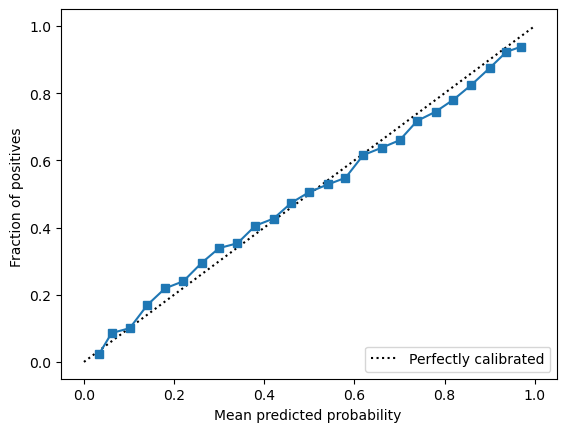

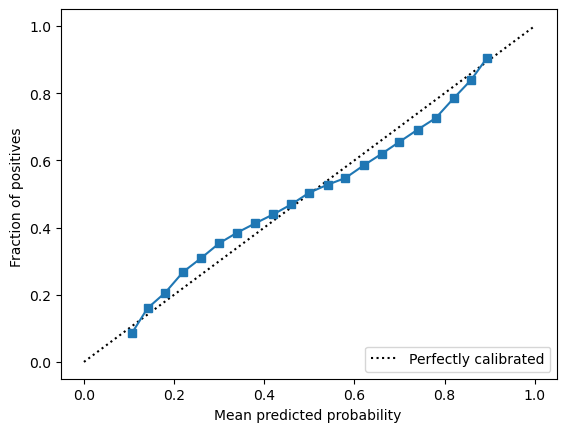

In [143]:

y_probs = xgb.predict_proba(X_test[model_cols])[:,1]
y_probs_elo = lin_model.predict_proba(lin_X_test)[:,1]

prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=25)
prob_true_lin, prob_pred_lin = calibration_curve(y_test, y_probs_elo, n_bins=25)

disp = CalibrationDisplay(prob_true, prob_pred, y_probs)
disp_lin = CalibrationDisplay(prob_true_lin, prob_pred_lin, y_probs_elo)

disp.plot()
disp_lin.plot()


In [145]:
idx =  model_df.loc[( model_df['player_one'] == 'Roger Federer')].index.values
x_idx = X_test.index

X_test['tourney_level'] =  model_df[ model_df.index.isin(x_idx)]['tourney_level']
X_test['model2_pred'] = xgb.predict_proba(X_test[model_cols])[:,1]
X_test['pred_diff'] = X_test['model2_pred'].sub(X_test['generic_player1_prob'])

X_test['result'] = y_test

<Axes: >

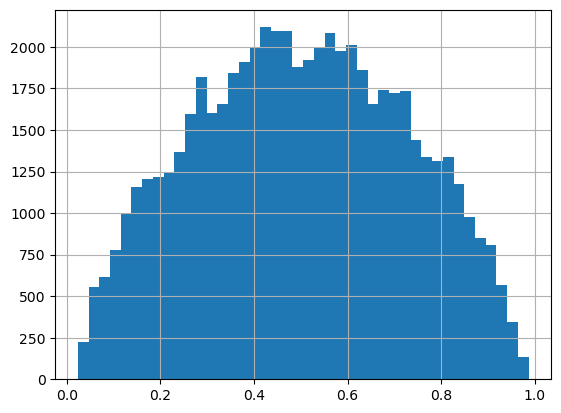

In [146]:
X_test['model2_pred'].hist(bins=42)

<Axes: >

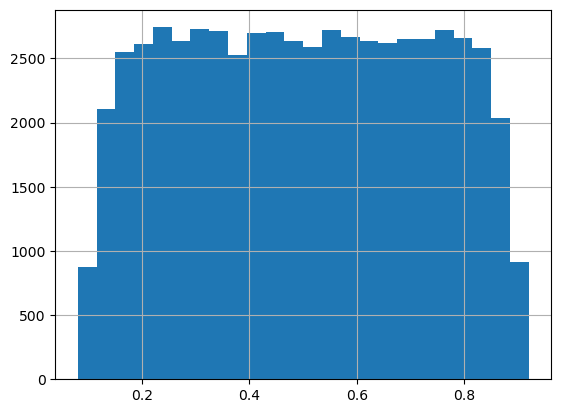

In [147]:
X_test['lin_model'] = lin_model.predict_proba(lin_X_test)[:,1]

X_test['lin_model'].hist(bins=24)

X_test.head(30)

In [46]:
X_test.groupby('tourney_level').apply(lambda x: brier_score_loss(x['result'], x['model2_pred']))

tourney_level
0.0    0.216872
1.0    0.211620
2.0    0.218953
3.0    0.202234
dtype: float64

In [70]:
X_test['p1_name'] = model_df[model_df.index.isin(X_test.index)]['player_one_name']

In [71]:
X_test['total_matches'] = X_test.groupby('p1_name').cumcount() + 1

X_test_filtered = X_test[X_test['total_matches'] >= 5].copy()